In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lightgbm import LGBMRegressor
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [ ]:
df = pd.read_csv('../data/19_25_Q2freesia_sol.CSV')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [39]:
# 기념일 영향도 계산 함수
def add_all_year_holiday_features(data):
    def get_flower_holidays(year):
        return {
            'Graduation': pd.to_datetime(f'{year}-02-10'),
            'Valentine': pd.to_datetime(f'{year}-02-14'),
            'WhiteDay': pd.to_datetime(f'{year}-03-14'),
            'ParentsDay': pd.to_datetime(f'{year}-05-08'),
            'TeachersDay': pd.to_datetime(f'{year}-05-15'),
            'Christmas': pd.to_datetime(f'{year}-12-25')
        }
    def calculate_min_dist(row):
        curr = row['date']
        hols = list(get_flower_holidays(curr.year).values()) + list(get_flower_holidays(curr.year + 1).values())
        future_hols = [h for h in hols if h >= curr]
        if not future_hols: return 0
        min_dist = (min(future_hols) - curr).days
        return max(0, 14 - min_dist) if min_dist <= 14 else 0

    data['holiday_impact'] = data.apply(calculate_min_dist, axis=1)
    return data

df = add_all_year_holiday_features(df)
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek

In [40]:
window_size = 3
future_steps = 7

# holiday_impact를 피처에 포함
features = ['total_quantity', 'total_amount', 'max_amount', 'mean', 'min_amount', 'holiday_impact']
targets = ['max_amount', 'mean', 'min_amount']

In [ ]:
# X_lags 생성
X_lags = []
for i in range(window_size, 0, -1):
    lag_df = df[features].shift(i)
    lag_df.columns = [f"{col}_lag{i}" for col in features]
    X_lags.append(lag_df)

X = pd.concat(X_lags + [df[['month', 'dayofweek', 'holiday_impact']]], axis=1)

# 타겟 데이터 생성 및 로그 변환
y_list = []
for i in range(1, future_steps + 1):
    target_shift = df[targets].shift(-i)
    target_shift = np.log1p(target_shift) # MAPE 최적화용 로그 변환
    target_shift.columns = [f"{col}_step{i}" for col in targets]
    y_list.append(target_shift)

y = pd.concat(y_list, axis=1)

# 결측치 제거
data = pd.concat([X, y], axis=1).dropna()
X_final = data[X.columns]
y_final = data[y.columns]

In [42]:
# 2025년 데이터를 테스트로 분리
split_date = '2025-01-01'
train_mask = df.loc[data.index, 'date'] < split_date
X_train, y_train = X_final[train_mask], y_final[train_mask]
X_test, y_test = X_final[~train_mask], y_final[~train_mask]

lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.03, num_leaves=10, random_state=42, verbose=-1)
model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)

joblib.dump(model, 'lgbm_flower_final_v4.pkl')

['lgbm_flower_final_v4.pkl']

In [43]:
sample_idx = 0 
preds_log = model.predict(X_test.iloc[[sample_idx]])[0]
actual_log = y_test.iloc[sample_idx].values

# 로그 복원
preds = np.expm1(preds_log).reshape(future_steps, 3) # [max, mean, min]
actual = np.expm1(actual_log).reshape(future_steps, 3)

# --- 오차 범위 지표 계산 ---
# 1. 일자별 MAPE (오차율 범위 확인용)
step_mapes = np.abs((actual[:, 1] - preds[:, 1]) / actual[:, 1]) * 100

# 2. 범위 적중률 (Hit Rate): 실제 평균가가 예측된 [최소~최대] 범위 안에 들어온 비율
hits = (actual[:, 1] >= preds[:, 2]) & (actual[:, 1] <= preds[:, 0])
hit_rate = np.mean(hits) * 100

print(f"--- 2025년 예측 성능 상세 분석 ---")
print(f"평균 MAPE: {np.mean(step_mapes):.2f}%")
print(f"최저~최고 MAPE 범위: {np.min(step_mapes):.2f}% ~ {np.max(step_mapes):.2f}%")
print(f"예측 범위 적중률 (Hit Rate): {hit_rate:.2f}% (실제값이 예측 Max-Min 사이에 존재할 확률)")

--- 2025년 예측 성능 상세 분석 ---
평균 MAPE: 25.45%
최저~최고 MAPE 범위: 5.35% ~ 57.55%
예측 범위 적중률 (Hit Rate): 85.71% (실제값이 예측 Max-Min 사이에 존재할 확률)


In [ ]:
kr_holidays_2025 = ['2025-01-01', '2025-01-27', '2025-01-28', '2025-01-29', '2025-01-30',
                    '2025-03-03', 
                    '2025-05-05', '2025-05-06', '2025-06-06', '2025-08-15',
                    '2025-10-03', '2025-10-06', '2025-10-07', '2025-10-08',
                    '2025-10-09', '2025-12-25'
                    ]
auction_cal = CustomBusinessDay(weekmask='Mon Wed Fri', holidays=kr_holidays_2025)
dates = pd.date_range(start=df.loc[X_test.index[sample_idx], 'date'], periods=future_steps, freq=auction_cal)

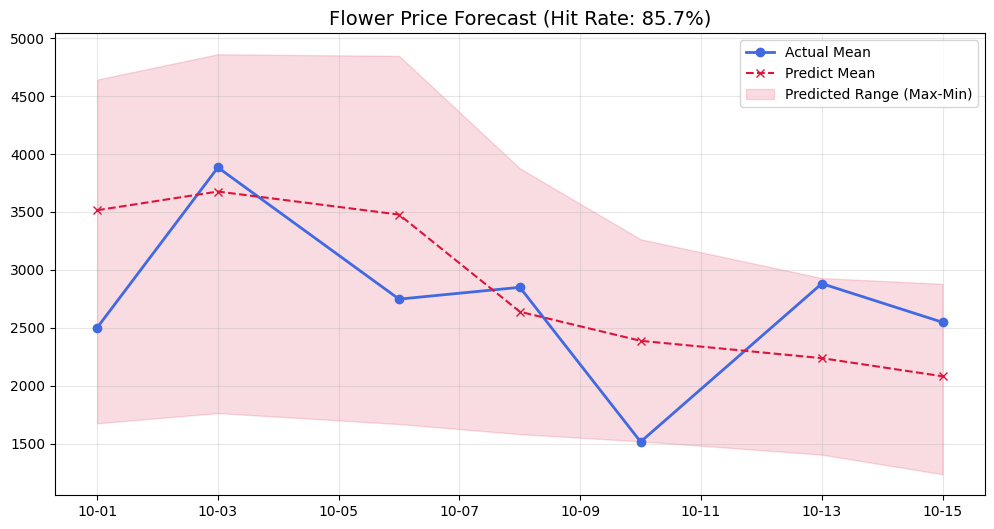

In [45]:
# --- 시각화 (범위 지표 포함) ---
plt.figure(figsize=(12, 6))
plt.plot(dates, actual[:, 1], 'o-', label='Actual Mean', color='royalblue', linewidth=2)
plt.plot(dates, preds[:, 1], 'x--', label='Predict Mean', color='crimson')

# 오차 범위 시각화 (Shaded Area)
plt.fill_between(dates, preds[:, 2], preds[:, 0], color='crimson', alpha=0.15, label='Predicted Range (Max-Min)')

plt.title(f"Flower Price Forecast (Hit Rate: {hit_rate:.1f}%)", fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
# 2026년 전체 분기를 반영한 경매 시장 휴무일
kr_holidays_2026 = [
    '2026-01-01', '2026-02-16', '2026-02-17', '2026-02-18', 
    '2026-03-02', '2026-05-05', '2026-05-25', '2026-08-17', 
    '2026-09-24', '2026-09-25', '2026-09-26', '2026-09-28', 
    '2026-10-05', '2026-10-09', '2026-12-25'
]

# 월, 수, 금 경매 주기 설정
auction_cal_2026 = CustomBusinessDay(weekmask='Mon Wed Fri', holidays=kr_holidays_2026)

In [47]:
# 1. 2025년의 가장 마지막 데이터(window_size만큼) 추출
# 이 데이터가 2026년 첫 예측의 '발판'이 됩니다.
last_window = df.iloc[-window_size:].copy()

# 2. 모델이 학습한 피처 순서와 동일하게 입력값 생성
# features 리스트: ['total_quantity', 'total_amount', 'max_amount', 'mean', 'min_amount', 'holiday_impact', 'mean_ma3', 'qty_ma3']
x_input_values = last_window[features].values.flatten()

# 3. 현재 시점 정보(마지막 날의 월, 요일, 기념일점수) 결합
# 'month', 'dayofweek', 'holiday_impact'
current_date_info = last_window[['month', 'dayofweek', 'holiday_impact']].iloc[-1].values
x_input = np.concatenate([x_input_values, current_date_info]).reshape(1, -1)

print("2026년 예측을 위한 입력 데이터 준비 완료")

2026년 예측을 위한 입력 데이터 준비 완료


In [48]:
# 1. 모델 예측 (로그 형태)
forecast_log = model.predict(x_input)[0]

# 2. 원래 가격 단위로 복원 (np.expm1)
forecast_final = np.expm1(forecast_log).reshape(future_steps, 3) # [Max, Mean, Min]

# 3. 2026년 예측 날짜 생성 (예: 2026년 4월 1일 이후 첫 경매일부터 시작)
start_date_2026 = pd.to_datetime('2026-04-01')
prediction_dates_2026 = pd.date_range(
    start=start_date_2026 + auction_cal_2026, 
    periods=future_steps, 
    freq=auction_cal_2026
)

print(f"2026년 {future_steps}회차 경매 예측 완료")

2026년 7회차 경매 예측 완료


C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRe

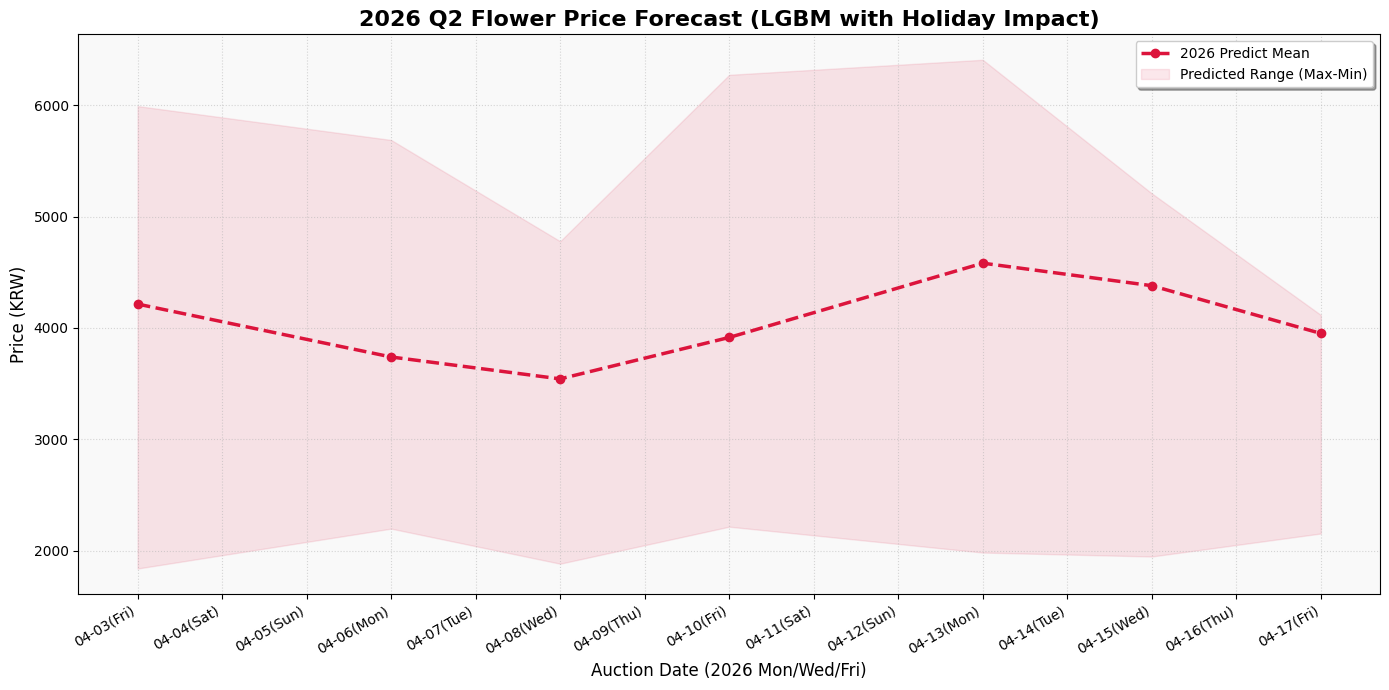

In [49]:
plt.figure(figsize=(14, 7))

# 예측 평균가 (굵은 점선)
plt.plot(prediction_dates_2026, forecast_final[:, 1], 
         label='2026 Predict Mean', color='crimson', 
         linestyle='--', marker='o', linewidth=2.5)

# 예측 범위 (Max-Min 음영)
plt.fill_between(prediction_dates_2026, 
                 forecast_final[:, 2], # Min
                 forecast_final[:, 0], # Max
                 color='crimson', alpha=0.1, label='Predicted Range (Max-Min)')

# x축 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d(%a)'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.title('2026 Q2 Flower Price Forecast (LGBM with Holiday Impact)', fontsize=16, fontweight='bold')
plt.xlabel('Auction Date (2026 Mon/Wed/Fri)', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.5)

# 배경색과 레이아웃 정리
plt.gca().set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()